# Introduction
This is the first section of the series "Three ways to build deep learning model in tensorflow".<br>
In this section you will learn about the sequential API. This API allows you to build deep learning model <br>
by stacking layers on top of each other. In this example, the task is to classify digits (0, 1, ..., 9).

# Import libraries


In [245]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Recall, Precision, AUC, CategoricalAccuracy
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore')
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Feedfoward network
The sequential API is perfect in implementing feedforward network also known as multilayers perceptron (MLP).<br>
In a multilayer perceptron (MLP) the input is fed into a series of hidden layers which produce an output: <br>
For example a MLP with 3 hidden layers and one output layer can be written as: <br>
<br>
output = output_layer(layer_3(layer_2(layer_1(input))))

In [246]:
# example 1
layer_1 = Dense(units=5, activation='relu', name='first_layer')
layer_2 = Dense(units=5, activation='relu', name='second_layer')
layer_3 = Dense(units=5, activation='relu', name='third_layer')
output_layer = Dense(units=1, activation='sigmoid')

input_x = tf.constant([[1,2,3,5]], name='input_x')
print(input_x)
output_y = output_layer(layer_3(layer_2(layer_1(input_x))))
print(layer_2.units)


tf.Tensor([[1 2 3 5]], shape=(1, 4), dtype=int32)
5


# Load the MINIST data set


In [247]:
dataset = tf.keras.datasets.mnist
(train_X, train_y), (test_X, test_y) = dataset.load_data()

In [248]:
train_y
train_y.shape

(60000,)

In [249]:
input_shape_1 = (train_X.shape[1], train_X.shape[2])
input_shape_2 = train_X.shape[1]*train_X.shape[2]
train_X.shape

(60000, 28, 28)

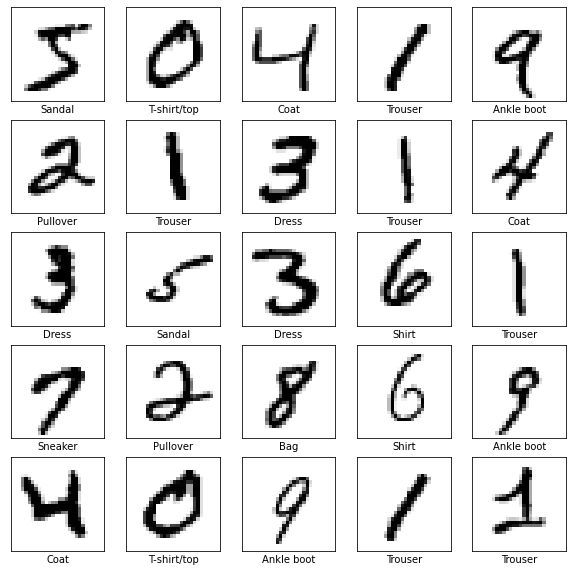

In [250]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_X[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_y[i]])
plt.show()

# Build a model with the sequential API

In [251]:
# set model parameters
first_layer_units = 128
second_layer_units = 128
output_layer_units = 10


# calculate model parameters
input_layer_params = 0
first_layer_params = first_layer_units*input_shape_1[0]*input_shape_1[1] + first_layer_units
output_layer_params = output_layer_units*first_layer_units + output_layer_units
total_params = first_layer_params + output_layer_params

# build a sequential model
sequential_model = Sequential([
    Flatten(input_shape=(28, 28), name='input_layer'),
    #Input(shape=(input_shape_2, ), name='input_layer')
    BatchNormalization(),
    Dense(units=first_layer_units, activation='relu', name='first_layer'),
    Dense(units=second_layer_units, activation='relu', name='second_layer'),
    #tf.keras.layers.Dropout(0.2),
    Dense(units=output_layer_units, activation='softmax', name='output_layer')
], name='senquential_classifier')


# model summary
sequential_model.summary()

Model: "senquential_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Flatten)        (None, 784)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 784)               3136      
_________________________________________________________________
first_layer (Dense)          (None, 128)               100480    
_________________________________________________________________
second_layer (Dense)         (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 121,418
Trainable params: 119,850
Non-trainable params: 1,568
_________________________________________________________________


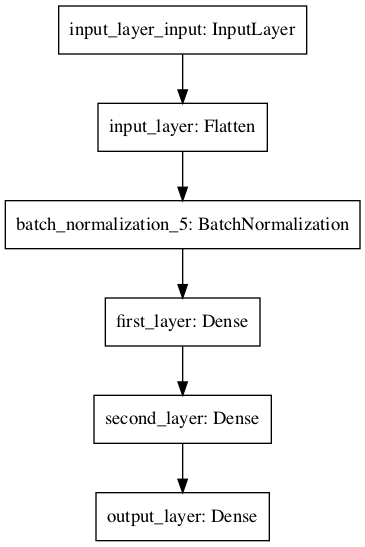

In [252]:
# model architecture plot
plot_model(sequential_model)

# Compile the model

In [253]:
sequential_model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Fit the model

In [243]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=2)

history = sequential_model.fit(x=train_X, y=train_y, epochs=150, callbacks=tensorboard_callback)


2021-09-06 15:20:06.744494: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-06 15:20:06.744514: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-06 15:20:06.745332: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/150
 135/1875 [=>............................] - ETA: 2s - loss: 1.7036 - accuracy: 0.4986

2021-09-06 15:20:07.151402: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-06 15:20:07.151415: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-06 15:20:07.170790: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-06 15:20:07.171584: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-06 15:20:07.172666: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20210906-152006/train/plugins/profile/2021_09_06_15_20_07

2021-09-06 15:20:07.173285: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fit/20210906-152006/train/plugins/profile/2021_09_06_15_20_07/Yapis-MacBook-Pro.local.trace.json.gz
2021-09-06 15:20:07.175254: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20210906-152006/t

1875/1875 [==============================] - 3s 1ms/step - loss: 0.4751 - accuracy: 0.8636
Epoch 2/150
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1956 - accuracy: 0.9419
Epoch 3/150
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1509 - accuracy: 0.9549
Epoch 4/150
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1221 - accuracy: 0.9629
Epoch 5/150
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1033 - accuracy: 0.9691
Epoch 6/150
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0879 - accuracy: 0.9728
Epoch 7/150
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0771 - accuracy: 0.9766
Epoch 8/150
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0678 - accuracy: 0.9791
Epoch 9/150
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0619 - accuracy: 0.9804
Epoch 10/150
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0550 

In [244]:
tensorboard --logdir=logs/fit --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 21391), started 1:32:31 ago. (Use '!kill 21391' to kill it.)